In [38]:
strategy_name ='鹏晖量化1号'

In [39]:
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\github\coresearch\funcs")
import rschLib
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang

In [40]:
#参数：
startDate = 20190101

In [41]:
def dtes2Label(dtes):
    return np.array([datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in dtes])


In [42]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1

In [43]:
with open(r"d:\pkl\dailyBarMtx.pkl", 'rb+') as f:
    z = pickle.load(f)
dtes = z['dtes']
dtes = np.array(dtes).astype(np.int)
tkrs = list(z['tkrs'])
open_mtx = z['open_mtx']
high_mtx = z['high_mtx']
low_mtx = z['low_mtx']
close_mtx = z['close_mtx']

k = close_mtx==0
close_mtx = rschLib.zero2pre(close_mtx)
open_mtx[k]=close_mtx[k]
high_mtx[k]=close_mtx[k]
low_mtx[k]=close_mtx[k]

name = z['name']
belong = z['belong']
shenwan1 = z['shenwan1']
shenwan2 = z['shenwan2']
shenwan3 = z['shenwan3']
vol_mtx = z['vol_mtx']
amount_mtx = z['amount_mtx']


In [44]:
dtes[-1]

20201022

In [28]:
mv = np.zeros(len(tkrs))
for (i,x) in enumerate(tkrs):
    q = db.tkrsInfo.find_one({'ticker':x},{'circulateMarketValue':1})
    if ('circulateMarketValue' in q)==False:
        continue
    mv[i] = q['circulateMarketValue']

In [29]:
#策略部分：
# 1.计算阻力位
# 2.计算高开破阻力位
# 3.收集交易，计算交易持仓到收盘，第二天开盘，第二天收盘的回报率
k = 1
N = 250 # 取N个交易日的高点作为阻力位
Nl = 250 # 取Nl个交易日的高点计算分位区间
openGapMax = 0.05 # 不要高开超过若干个点的
openGapMin = 0.01 # 不要高开低于若干个点的
thresPriceLoc = 2  # 价格在历史价格区间的分位数
highVolumeThres = 0 # 前一天成交量是再前一天成交量的倍数
intradayFall = -0.075 # 允许今日收盘较开盘最多下跌点数
preHigh = np.zeros(close_mtx.shape)
preHighLoc = np.zeros(close_mtx.shape)
idxOpenHigh = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxPriceLoc = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxHighVolume = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxNotNewStock = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxPreDayNotBreakHigh = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxNotAllDayZhangTing = np.array(np.zeros(close_mtx.shape), dtype='bool')  #  今日未开板
idxOpenSmallerThanGapMax = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxOpenBiggerThanGapMin = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxNotZhangtingAtClose = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxNotZhangtingAtAnyMoment = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxLowBiggerThanPreHigh = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxOpenAtZhangTing = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxCloseNotSmallerThanIntradayFall = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日收盘价较今日开盘价不能在intradayFall以下
idxQ = np.array(np.zeros(close_mtx.shape), dtype='bool')
for k in range(close_mtx.shape[1]-1):
    q = np.max((0, k-N))
    preHigh[:, k+1] = np.max(high_mtx[:, q:k+1], axis=1)
    for di in range(len(tkrs)):
        preHighLoc[di, k+1]=k+1-np.nonzero(preHigh[di, k+1]==high_mtx[di, :k+1])[0][-1]
    q = np.max((0, k-Nl))
    idxPriceLoc[:, k+1] = close_mtx[:,k]/preHigh[:, k+1]<thresPriceLoc
    idxHighVolume[:, k+1] = amount_mtx[:, k]/amount_mtx[:, k-1]>highVolumeThres
    #idxOpenHigh[:, k+1] = idxHighVolume[:, k+1] & (close_mtx[:, k] < preHigh[:, k+1]) & (open_mtx[:, k+1] > preHigh[:, k+1]) & (open_mtx[:, k+1]!=high_mtx[:, k+1]) & ((open_mtx[:, k+1]/preHigh[:,k+1]-1)<openGapMax)& ((open_mtx[:, k+1]/preHigh[:, k+1]-1)>openGapMin)  
    #idxOpenHigh[:, k+1] = ((open_mtx[:, k+1]/preHigh[:,k+1]-1)<openGapMax)& ((open_mtx[:, k+1]/preHigh[:, k+1]-1)>openGapMin)  
    idxPreDayNotBreakHigh[:, k+1] = high_mtx[:, k] < preHigh[:, k] # 昨日未创新高
    idxNotAllDayZhangTing[:, k+1] = (low_mtx[:, k+1]!=high_mtx[:, k+1])  #  今日未开板
    idxOpenSmallerThanGapMax[:, k+1] = ((open_mtx[:, k+1]/preHigh[:,k+1]-1)<openGapMax) # 今日开盘价高出preHigh在openGapMax以下
    idxOpenBiggerThanGapMin[:, k+1] = ((open_mtx[:, k+1]/preHigh[:,k+1]-1)>openGapMin) # 今日开盘价高出preHigh在openGapMax以下
    idxOpenHigh[:, k+1] = (open_mtx[:, k+1] > preHigh[:, k+1])
    idxOpenAtZhangTing[:, k+1] = (open_mtx[:, k+1] / close_mtx[:, k] - 1)>0.095
    idxNotZhangtingAtClose[:, k+1]= (close_mtx[:, k+1] / close_mtx[:, k] - 1)<0.095
    idxNotZhangtingAtAnyMoment[:, k+1]= (high_mtx[:, k+1] / close_mtx[:, k] - 1)<0.095
    idxNotNewStock[:, k+1] = False==np.any(open_mtx[:, np.max((0, k-90)):k+1]==0, axis=1)
    idxLowBiggerThanPreHigh[:, k+1] = (low_mtx[:,k+1] > preHigh[:, k+1])
    idxCloseNotSmallerThanIntradayFall[:, k+1] = (close_mtx[:, k+1] / open_mtx[:, k+1] -1) > intradayFall



C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\An

In [30]:
def calculateProfit(idxQ, title1, detail='no', detailTrade=8, off=1, startDate=20150101):
    now = time.strftime("%Y%m%d %H:%M:%S",time.localtime(time.time()))
    if detail=='yes':
        db.strategyBackTestTrades.remove({'strategy_name':strategy_name})
    r1 = np.zeros((len(dtes)))
    r2 = np.zeros((len(dtes)))
    r3 = np.zeros((len(dtes)))
    r4 = np.zeros((len(dtes)))
    r5 = np.zeros((len(dtes)))
    r6 = np.zeros((len(dtes)))
    r7 = np.zeros((len(dtes)))
    r8 = np.zeros((len(dtes)))
    f = open("output.txt", "w")
    f2 = open("output2.txt", "w")
    for k in range(10,close_mtx.shape[1]):
        close_yesterday = close_mtx[idxQ[:,k], k-1]
        close_today = close_mtx[idxQ[:,k], k]
        open_today = open_mtx[idxQ[:,k], k]
        high_today = high_mtx[idxQ[:,k],k]
        if k+1<len(dtes):
            close_tomorrow = close_mtx[idxQ[:,k], k+1]
            open_tomorrow = open_mtx[idxQ[:,k], k+1]
        else:
            close_tomorrow = close_today #如果是今天的数据，则没有明天收盘价格，采用今天收盘价
            open_tomorrow = close_today  #如果是今天的数据，则没有明天收盘价格，采用今天收盘价
        if k+2<len(dtes):
            open_2 = open_mtx[idxQ[:,k], k+2]
        else:
            open_2 = close_tomorrow  #如果是今天的数据，则没有明天收盘价格，采用今天收盘价
        if k+off<len(dtes):
            close_off = close_mtx[idxQ[:,k], k+off] 
        else:
            close_off = close_today #如果是今天的数据，则没有明天收盘价格，采用今天收盘价
        std10d = np.std(close_mtx[idxQ[:, k],k-9:k-1]/close_mtx[idxQ[:,k],k-10:k-2]-1,axis=1)
        r1[k]=(np.mean(close_today/open_today-1))
        r2[k]=(np.mean(open_tomorrow/open_today-1))
        r3[k]=(np.mean((open_2/open_tomorrow-1)))
        r4[k]=(np.mean(close_off/close_today-1))/off
        r5[k]=(np.mean(close_off/open_tomorrow-1))/off
        r6[k]=(np.mean(close_tomorrow/close_today-1))
        r7[k]=(np.mean(open_tomorrow/close_today-1))
        intradayHigh = high_mtx[idxQ[:,k], k]
        idxZhangTing = high_mtx[idxQ[:,k], k]/close_yesterday-1 > 0.095
        t = name[idxQ[:,k]]
        cbuy = close_today.copy()
        cbuy[idxZhangTing] = intradayHigh[idxZhangTing]
        r8[k]=(np.mean(close_off/cbuy-1))/off
        daysFromPreHigh = preHighLoc[idxQ[:,k],k]
        mvk = mv[idxQ[:, k]]
        pp = np.max([0, k-5])
        pp2 = np.max([0, k-10])
        return5d = close_mtx[idxQ[:,k],k-1]/close_mtx[idxQ[:,k],pp]-1
        return10d = close_mtx[idxQ[:,k],k-1]/close_mtx[idxQ[:,k],pp2]-1
        if (len(t)>0) & (detail=='yes') & (dtes[k]>startDate):
            if (detailTrade==8):
                s2='总笔:,'+str(dtes[k])+',共交易,'+str(len(t))+',每天平均利润,'+str(np.round(r8[k]*1e4)/1e2)+',(%)'
                #print(s2)
                f2.write(s2+'\n')
            if (detailTrade==3):
                s2='总笔:,'+str(dtes[k])+',共交易,'+str(len(t))+',每天平均利润,'+str(np.round(r3[k]*1e4)/1e2)+',(%)'
                #print(s2)
                f2.write(s2+'\n')
            for i in range(len(t)):
                if (detailTrade==8):
                    print('分笔:',t[i], 
                          dtes[k],
                          '盘中涨停？',str(idxZhangTing[i]),
                          '买入价:', np.round(cbuy[i], 2),
                          '卖出价：',
                          np.round(close_off[i],2), 
                          '利润:',
                          str(np.round(1e4*(close_off[i]/cbuy[i]-1))/1e2)+'%',
                          '参考信息： 第二日收盘价较前一日收盘：',
                          str(np.round(1e4*(close_today[i]/close_yesterday[i]-1))/1e2)+'%')
                if (detailTrade==3):
                    s='分笔:,'+str(t[i])+','+str(dtes[k])\
                                     +',盘中涨停？,'+str(idxZhangTing[i])\
                                     +',买入价(第二天开盘),'+str(np.round(open_tomorrow[i], 2))\
                                     +',卖出价(第三天开盘),'+str(np.round(open_2[i], 2))\
                                     +',利润:,'+str(np.round(1e4*(open_2[i]/open_tomorrow[i]-1))/1e2)+',(%)'\
                                     +',参考信息： 今天收盘价较前一天收盘,'\
                                     +str(np.round(1e4*(close_today[i]/close_yesterday[i]-1))/1e2)+',(%)'\
                                     +',参考信息： 今天收盘价较开盘,'\
                                     +str(np.round(1e4*(close_today[i]/open_today[i]-1))/1e2)+',(%)'\
                                     +',距离前高点,'+str(daysFromPreHigh[i])\
                                     +',流通市值,'+str(mvk[i])\
                                     +',过去五日回报率,'+str(return5d[i])\
                                     +',过去十日回报率,'+str(return10d[i])\
                                     +',近期波动率,'+str(std10d[i])\
                                     +',第一天高点到收盘,'+str(np.round(1e4*(high_today[i]/close_today[i]-1))/1e2)
                    db.strategyBackTestTrades.insert_one({
                        'name':str(t[i]),
                        'dateIn':int(dtes[k]), 
                        'strategy_name':strategy_name,
                        '买入价':np.round(open_tomorrow[i], 2),
                        '卖出价':np.round(open_2[i], 2)})
                    f.write(s+'\n')
                    print(s)
    f.close()
    f2.close()
    r1[~np.isfinite(r1)]=0
    r2[~np.isfinite(r2)]=0
    r3[~np.isfinite(r3)]=0
    r4[~np.isfinite(r4)]=0
    r5[~np.isfinite(r5)]=0
    r6[~np.isfinite(r6)]=0
    r7[~np.isfinite(r7)]=0
    r8[~np.isfinite(r8)]=0
    
    xs = [datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in dtes]
    plt.plot(xs, np.sum(idxQ, axis=0))
    plt.title(title1)
    plt.show
    #
    plt.figure()
    plt.plot(dtes2Label(dtes[dtes>startDate]), np.cumsum(r1[dtes>startDate]))
    plt.plot(dtes2Label(dtes[dtes>startDate]), np.cumsum(r2[dtes>startDate]),'r')
    plt.plot(dtes2Label(dtes[dtes>startDate]), np.cumsum(r3[dtes>startDate]),'g')
    plt.plot(dtes2Label(dtes[dtes>startDate]), np.cumsum(r4[dtes>startDate]),'y')
    plt.plot(dtes2Label(dtes[dtes>startDate]), np.cumsum(r5[dtes>startDate]),'y--')
    plt.plot(dtes2Label(dtes[dtes>startDate]), np.cumsum(r6[dtes>startDate]),'m')
    plt.plot(dtes2Label(dtes[dtes>startDate]), np.cumsum(r7[dtes>startDate]),'k')
    plt.plot(dtes2Label(dtes[dtes>startDate]), np.cumsum(r8[dtes>startDate]),'c')
    plt.legend(['开盘到收盘回报率','开盘到第二天开盘回报率','第二天开盘到第三天开盘','收盘到第'+str(off+1)+'天收盘回报率','第二天开盘到第'+str(off+1)+'天收盘回报率','收盘到第二天收盘回报率','收盘到第二天开盘','收盘到第'+str(off+1)+'天收盘回报率（接近板则追板）'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title1='每天高开股票数目'
    plt.title('回报率图')
    plt.grid()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m'))
    plt.gcf().autofmt_xdate()  # 自动旋转日期标记
    return r1[dtes>startDate],r2[dtes>startDate],r3[dtes>startDate],r4[dtes>startDate],r5[dtes>startDate],r6[dtes>startDate],r7[dtes>startDate],r8[dtes>startDate], dtes[dtes>startDate]

In [31]:
#筛选条件

#开盘后有机会进入， 如果接近打板则打板，否则收盘买
#idxQ = idxOpenHigh & idxNotNewStock & idxPreDayNotBreakHigh & idxOpenAtZhangTing

#开盘后必须开盘价在板上才能买入
#idxQ = idxOpenHigh & idxNotNewStock & idxPreDayNotBreakHigh & idxOpenAtZhangTing

#开盘后开盘价不在涨停板上，如果接近打板则打板，否则收盘买
#idxQ = idxOpenHigh & idxNotNewStock & idxPreDayNotBreakHigh & ~idxOpenAtZhangTing

#收盘价在涨停上
#idxQ = idxOpenHigh & idxNotNewStock & idxPreDayNotBreakHigh & (idxNotZhangtingAtClose==False)

#收盘价不在涨停上，第二天开盘买入
idxQ = idxOpenHigh & idxNotNewStock & idxPreDayNotBreakHigh & idxNotZhangtingAtClose & idxCloseNotSmallerThanIntradayFall


#收盘价不在涨停上，盘中一度涨停
#idxQ = idxOpenHigh & idxNotNewStock & idxPreDayNotBreakHigh & idxNotZhangtingAtClose & idxCloseNotSmallerThanIntradayFall & (idxNotZhangtingAtAnyMoment==False)



C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


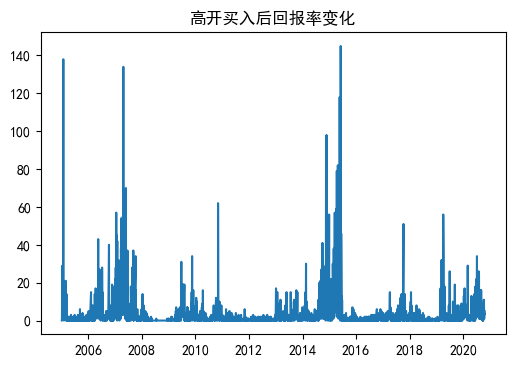

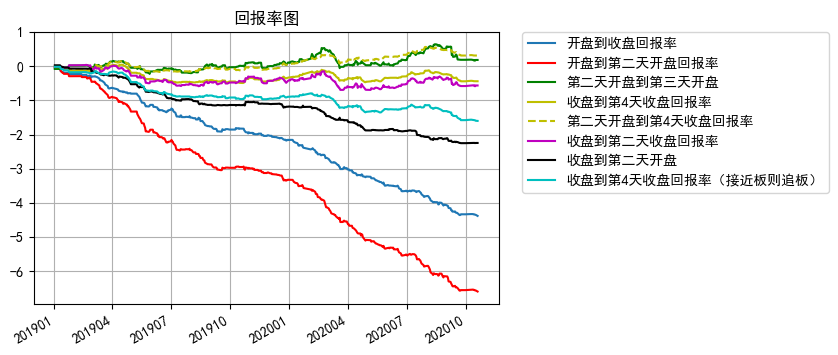

In [32]:
[r1, r2, r3, r4, r5,r6,r7,r8,dtesUsed] = calculateProfit(idxQ, '高开买入后回报率变化', off=3, startDate=startDate)

In [33]:
q = list(db.tkrsInfo.find({},{'ticker':1,'circulateMarketValue20190101':1,'circulateMarketValue20200101':1,'circulateMarketValue':1}))
cmv2019 = np.zeros(len(tkrs))
cmv2020 = np.zeros(len(tkrs))
cmv = np.zeros(len(tkrs))
for x in q:
    if (x['ticker'] in list(tkrs))==False:
        continue
    if 'circulateMarketValue20190101' in x:
        cmv2019[list(tkrs).index(x['ticker'])]=x['circulateMarketValue20190101']
        cmv[list(tkrs).index(x['ticker'])]=x['circulateMarketValue']
    if 'circulateMarketValue20200101' in x:
        cmv2020[list(tkrs).index(x['ticker'])]=x['circulateMarketValue20200101']


选股池大小： 1004


C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


分笔:,深高速  ,20190219,盘中涨停？,False,买入价(第二天开盘),8.36,卖出价(第三天开盘),8.43,利润:,0.85,(%),参考信息： 今天收盘价较前一天收盘,0.32,(%),参考信息： 今天收盘价较开盘,-2.48,(%),距离前高点,6.0,流通市值,1256978.0759019998,过去五日回报率,0.0021276595744679216,过去十日回报率,0.04318936877076407,近期波动率,0.012758958772609576,第一天高点到收盘,7.41
分笔:,高德红外,20190219,盘中涨停？,False,买入价(第二天开盘),8.97,卖出价(第三天开盘),9.38,利润:,4.57,(%),参考信息： 今天收盘价较前一天收盘,-0.39,(%),参考信息： 今天收盘价较开盘,-1.74,(%),距离前高点,3.0,流通市值,4349075.85441,过去五日回报率,0.012630662020905792,过去十日回报率,0.09308885754583929,近期波动率,0.029186646651486004,第一天高点到收盘,1.77
分笔:,济民制药,20190221,盘中涨停？,False,买入价(第二天开盘),15.37,卖出价(第三天开盘),15.35,利润:,-0.13,(%),参考信息： 今天收盘价较前一天收盘,1.25,(%),参考信息： 今天收盘价较开盘,-2.91,(%),距离前高点,2.0,流通市值,1193280.0,过去五日回报率,-0.014944769330734298,过去十日回报率,0.055710306406685284,近期波动率,0.01586514037815903,第一天高点到收盘,3.0
分笔:,世纪华通,20190221,盘中涨停？,True,买入价(第二天开盘),11.84,卖出价(第三天开盘),11.08,利润:,-6.42,(%),参考信息： 今天收盘价较前一天收盘,1.59,(%),参考信息： 今天收盘价较开盘,-7.44,(%),距离前高点,60.0,流通市值,3955522.873338,过去五日回报率,0.050000000000000044,过去十日回报率,0.14903595622720167,近期波动率,0.013109

分笔:,兴森科技,20190521,盘中涨停？,True,买入价(第二天开盘),5.96,卖出价(第三天开盘),5.97,利润:,0.17,(%),参考信息： 今天收盘价较前一天收盘,8.28,(%),参考信息： 今天收盘价较开盘,1.95,(%),距离前高点,46.0,流通市值,1411523.3268119998,过去五日回报率,0.21338912133891208,过去十日回报率,0.2500000000000002,近期波动率,0.038742584275225346,第一天高点到收盘,1.59
分笔:,北方稀土,20190522,盘中涨停？,False,买入价(第二天开盘),12.77,卖出价(第三天开盘),12.54,利润:,-1.79,(%),参考信息： 今天收盘价较前一天收盘,-0.24,(%),参考信息： 今天收盘价较开盘,-5.7,(%),距离前高点,248.0,流通市值,4054501.656,过去五日回报率,0.252208047105005,过去十日回报率,0.31140801644398763,近期波动率,0.03746195558999021,第一天高点到收盘,6.05
分笔:,新 希 望,20190530,盘中涨停？,False,买入价(第二天开盘),19.67,卖出价(第三天开盘),21.06,利润:,7.07,(%),参考信息： 今天收盘价较前一天收盘,5.6,(%),参考信息： 今天收盘价较开盘,3.15,(%),距离前高点,2.0,流通市值,12402126.968004,过去五日回报率,0.07027649769585231,过去十日回报率,0.055082339579784145,近期波动率,0.049694028798214954,第一天高点到收盘,0.92
分笔:,有研新材,20190610,盘中涨停？,False,买入价(第二天开盘),13.17,卖出价(第三天开盘),14.17,利润:,7.58,(%),参考信息： 今天收盘价较前一天收盘,0.82,(%),参考信息： 今天收盘价较开盘,-3.83,(%),距离前高点,6.0,流通市值,1185642.124388,过去五日回报率,0.09624796084828713,过去十日回报率,0.4177215189873418,近期波动率,0.065192772586

分笔:,长亮科技,20190910,盘中涨停？,True,买入价(第二天开盘),13.33,卖出价(第三天开盘),12.7,利润:,-4.7,(%),参考信息： 今天收盘价较前一天收盘,4.69,(%),参考信息： 今天收盘价较开盘,-4.83,(%),距离前高点,245.0,流通市值,1483783.082448,过去五日回报率,0.17160120845921445,过去十日回报率,0.20584577114427893,近期波动率,0.029530431560664365,第一天高点到收盘,5.07
分笔:,杰瑞股份,20190916,盘中涨停？,False,买入价(第二天开盘),28.31,卖出价(第三天开盘),27.01,利润:,-4.57,(%),参考信息： 今天收盘价较前一天收盘,4.68,(%),参考信息： 今天收盘价较开盘,-1.88,(%),距离前高点,3.0,流通市值,1733812.228625,过去五日回报率,0.021607278241091876,过去十日回报率,0.039737654320987525,近期波动率,0.02563266785133946,第一天高点到收盘,3.33
分笔:,东方时尚,20190919,盘中涨停？,True,买入价(第二天开盘),19.1,卖出价(第三天开盘),19.75,利润:,3.41,(%),参考信息： 今天收盘价较前一天收盘,8.8,(%),参考信息： 今天收盘价较开盘,6.99,(%),距离前高点,114.0,流通市值,1185408.0,过去五日回报率,0.04849201655824986,过去十日回报率,0.05535714285714288,近期波动率,0.01441267820287631,第一天高点到收盘,1.09
分笔:,艾迪精密,20190920,盘中涨停？,False,买入价(第二天开盘),18.72,卖出价(第三天开盘),18.48,利润:,-1.32,(%),参考信息： 今天收盘价较前一天收盘,-1.2,(%),参考信息： 今天收盘价较开盘,-3.07,(%),距离前高点,4.0,流通市值,3243260.4441600004,过去五日回报率,0.03389830508474567,过去十日回报率,0.05132133282267315,近期波动率,0.0112101517

分笔:,中文传媒,20200108,盘中涨停？,False,买入价(第二天开盘),17.54,卖出价(第三天开盘),16.46,利润:,-6.18,(%),参考信息： 今天收盘价较前一天收盘,1.93,(%),参考信息： 今天收盘价较开盘,-4.57,(%),距离前高点,203.0,流通市值,1598975.18842,过去五日回报率,0.29390154298310067,过去十日回报率,0.33814589665653494,近期波动率,0.033264915535715145,第一天高点到收盘,4.79
分笔:,海油工程,20200108,盘中涨停？,False,买入价(第二天开盘),7.6,卖出价(第三天开盘),7.75,利润:,1.95,(%),参考信息： 今天收盘价较前一天收盘,0.38,(%),参考信息： 今天收盘价较开盘,-2.95,(%),距离前高点,2.0,流通市值,1989609.66,过去五日回报率,0.0650406504065042,过去十日回报率,0.1731343283582092,近期波动率,0.023501843105540127,第一天高点到收盘,3.93
分笔:,中海油服,20200108,盘中涨停？,False,买入价(第二天开盘),19.15,卖出价(第三天开盘),19.02,利润:,-0.67,(%),参考信息： 今天收盘价较前一天收盘,-0.64,(%),参考信息： 今天收盘价较开盘,-4.93,(%),距离前高点,2.0,流通市值,3522956.92,过去五日回报率,0.05208333333333326,过去十日回报率,0.09842305600870027,近期波动率,0.02914628275996092,第一天高点到收盘,5.63
分笔:,TCL科技,20200108,盘中涨停？,False,买入价(第二天开盘),4.72,卖出价(第三天开盘),4.67,利润:,-1.04,(%),参考信息： 今天收盘价较前一天收盘,3.28,(%),参考信息： 今天收盘价较开盘,-1.87,(%),距离前高点,8.0,流通市值,7482036.527844001,过去五日回报率,0.022371364653243964,过去十日回报率,0.022371364653243964,近期波动率,0.02356183273476

分笔:,健友股份,20200415,盘中涨停？,False,买入价(第二天开盘),42.3,卖出价(第三天开盘),42.18,利润:,-0.27,(%),参考信息： 今天收盘价较前一天收盘,-3.26,(%),参考信息： 今天收盘价较开盘,-4.3,(%),距离前高点,4.0,流通市值,3603864.4960080003,过去五日回报率,0.052961801070308345,过去十日回报率,0.13034865293185427,近期波动率,0.022918388221768678,第一天高点到收盘,4.49
分笔:,南极电商,20200417,盘中涨停？,False,买入价(第二天开盘),13.72,卖出价(第三天开盘),13.97,利润:,1.81,(%),参考信息： 今天收盘价较前一天收盘,6.12,(%),参考信息： 今天收盘价较开盘,2.74,(%),距离前高点,229.0,流通市值,3782250.910064,过去五日回报率,0.1566371681415928,过去十日回报率,0.12867012089810004,近期波动率,0.03292886290861651,第一天高点到收盘,3.1
分笔:,广电运通,20200417,盘中涨停？,True,买入价(第二天开盘),10.67,卖出价(第三天开盘),11.69,利润:,9.56,(%),参考信息： 今天收盘价较前一天收盘,2.98,(%),参考信息： 今天收盘价较开盘,-5.04,(%),距离前高点,38.0,流通市值,3078269.92086,过去五日回报率,0.11324786324786307,过去十日回报率,0.16816143497757818,近期波动率,0.03856547758400377,第一天高点到收盘,6.8
分笔:,华大基因,20200421,盘中涨停？,False,买入价(第二天开盘),105.73,卖出价(第三天开盘),112.93,利润:,6.81,(%),参考信息： 今天收盘价较前一天收盘,-1.61,(%),参考信息： 今天收盘价较开盘,-3.83,(%),距离前高点,2.0,流通市值,3602110.55115,过去五日回报率,0.24127650176678417,过去十日回报率,0.35466377440347063,近期波动率,0.0493949

分笔:,中国一重,20200707,盘中涨停？,False,买入价(第二天开盘),3.24,卖出价(第三天开盘),3.5,利润:,8.02,(%),参考信息： 今天收盘价较前一天收盘,-0.91,(%),参考信息： 今天收盘价较开盘,-6.3,(%),距离前高点,244.0,流通市值,1928710.0,过去五日回报率,0.17437722419928825,过去十日回报率,0.1418685121107266,近期波动率,0.0145285165709317,第一天高点到收盘,9.48
分笔:,新华保险,20200707,盘中涨停？,False,买入价(第二天开盘),54.64,卖出价(第三天开盘),56.87,利润:,4.09,(%),参考信息： 今天收盘价较前一天收盘,1.96,(%),参考信息： 今天收盘价较开盘,-1.73,(%),距离前高点,247.0,流通市值,14076715.545,过去五日回报率,0.25587172538392045,过去十日回报率,0.22895027624309394,近期波动率,0.0265666433187618,第一天高点到收盘,5.24
分笔:,光大银行,20200707,盘中涨停？,False,买入价(第二天开盘),4.35,卖出价(第三天开盘),4.37,利润:,0.46,(%),参考信息： 今天收盘价较前一天收盘,0.45,(%),参考信息： 今天收盘价较开盘,-5.73,(%),距离前高点,178.0,流通市值,16123294.325969998,过去五日回报率,0.23463687150837975,过去十日回报率,0.2283464566929132,近期波动率,0.024592791758766074,第一天高点到收盘,8.11
分笔:,深科技,20200707,盘中涨停？,False,买入价(第二天开盘),26.23,卖出价(第三天开盘),27.86,利润:,6.21,(%),参考信息： 今天收盘价较前一天收盘,4.67,(%),参考信息： 今天收盘价较开盘,-0.68,(%),距离前高点,35.0,流通市值,3267110.1744159996,过去五日回报率,0.147503435639029,过去十日回报率,0.07326478149100257,近期波动率,0.025823981456182

分笔:,日月股份,20200914,盘中涨停？,False,买入价(第二天开盘),22.56,卖出价(第三天开盘),23.03,利润:,2.08,(%),参考信息： 今天收盘价较前一天收盘,4.0,(%),参考信息： 今天收盘价较开盘,-0.13,(%),距离前高点,44.0,流通市值,2076628.25007,过去五日回报率,0.07574257425742581,过去十日回报率,0.05845104724792982,近期波动率,0.0179397235432756,第一天高点到收盘,1.28
分笔:,岱美股份,20200916,盘中涨停？,False,买入价(第二天开盘),28.01,卖出价(第三天开盘),28.15,利润:,0.5,(%),参考信息： 今天收盘价较前一天收盘,0.21,(%),参考信息： 今天收盘价较开盘,-1.58,(%),距离前高点,4.0,流通市值,1551987.7779120002,过去五日回报率,0.03857566765578624,过去十日回报率,0.10759493670886067,近期波动率,0.017855562133538345,第一天高点到收盘,4.53
分笔:,欣旺达,20200917,盘中涨停？,False,买入价(第二天开盘),28.71,卖出价(第三天开盘),28.5,利润:,-0.73,(%),参考信息： 今天收盘价较前一天收盘,4.44,(%),参考信息： 今天收盘价较开盘,0.42,(%),距离前高点,3.0,流通市值,3932771.3192459997,过去五日回报率,0.10450160771704176,过去十日回报率,0.03776435045317217,近期波动率,0.031144707062238302,第一天高点到收盘,3.41
分笔:,新华保险,20200921,盘中涨停？,False,买入价(第二天开盘),64.39,卖出价(第三天开盘),63.45,利润:,-1.46,(%),参考信息： 今天收盘价较前一天收盘,-3.53,(%),参考信息： 今天收盘价较开盘,-6.37,(%),距离前高点,25.0,流通市值,14076715.545,过去五日回报率,0.1499229847680985,过去十日回报率,0.18292253521126756,近期波动率,0.0315967

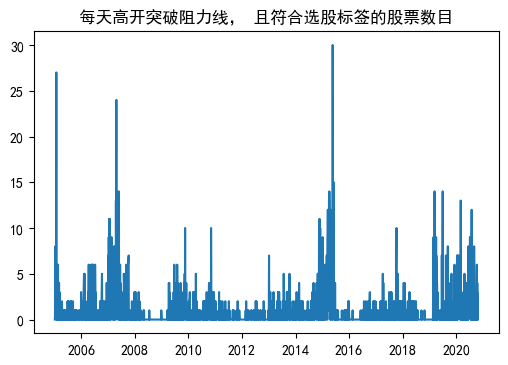

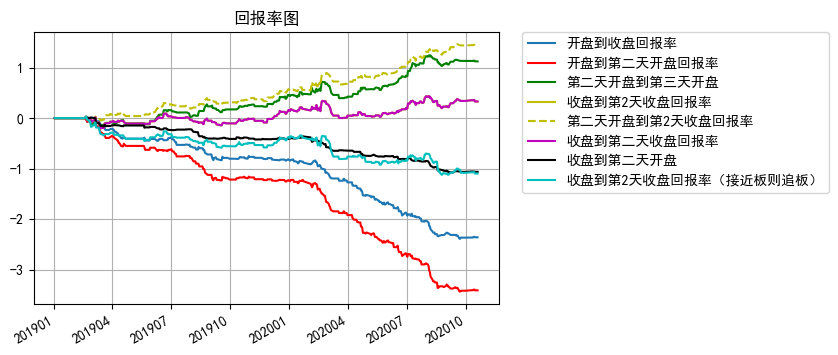

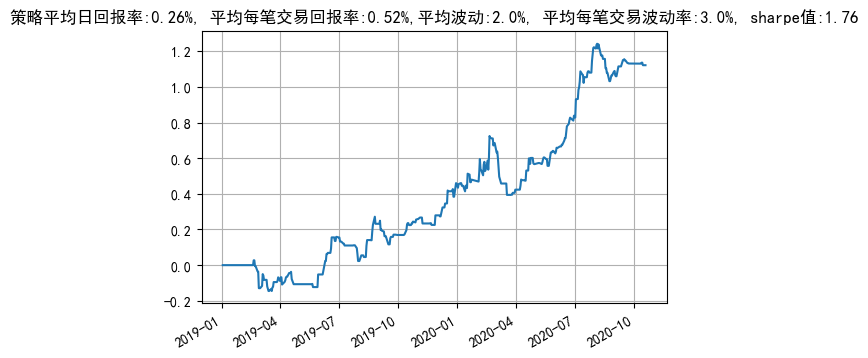

In [34]:
#只选一部分股票
# 流通市值>500亿
wants1 = ['SH603288','SH601216','SH601012','SH600436','SH603806','SZ002352','SH601633','SH601899','SZ002311','SZ002271','SH600763','SZ000858','SZ000895','SZ002493','SH600176','SZ300124','SZ000596','SH600298','SH600872','SZ000568','SH600893','SH600887','SH600309','SH601788','SH600438','SH601888','SH600346','SH603338','SH600809','SZ002044','SH601877','SZ002241','SH600926','SZ002049','SZ300433','SH603517','SZ000786','SH600521','SZ002157','SH600196','SZ300059','SH603369','SZ000876','SH600519','SZ000538','SZ002032','SZ000157','SH603259','SH600660','SZ000987','SH601628','SH601066','SH600570','SZ000661','SH603899','SZ000656','SH600011','SH600030','SZ002027','SZ300122','SZ300015','SZ002142','SZ002475','SZ002414','SZ002179','SZ002555','SH600600','SH600886','SZ002714','SZ002304','SH601100','SZ300750','SH600023','SZ000768','SZ300760','SZ002415','SH601377','SH603939','SZ002594','SZ300347','SH601881','SH601878','SZ002001','SH601985','SH603833','SH601336','SZ300413','SZ000860','SZ002007','SH603233','SZ300601','SH600900','SH601225','SZ002736','SH601211','SZ000333','SZ300136','SH600741','SH600406','SZ000725','SZ000166','SZ000069','SH600031','SH600958','SZ000066','SH600837','SZ300142','SH600845','SZ002821','SH600276','SH600061','SZ300014','SH601901','SZ002050','SZ000776','SH601688','SH601155','SZ000100','SH601618','SH600919','SH601009','SZ002624','SZ002410','SH601989','SZ300498','SH603993','SH600161','SH600588','SZ002230','SZ000938','SH600585','SH603019','SH601231','SZ300003','SH601727','SZ002371','SH601229','SZ300558','SH600547','SH601390','SH600036','SZ000001','SH600019','SH600018','SZ002024','SH601238','SZ000338','SH601088','SH600104','SH601601','SH600233','SH600048','SH600383','SZ000002','SH601998','SZ002129','SH601668','SH601857','SH601169','SH601800','SH600015','SH600703','SH601818','SH603658','SH601186','SH601166','SH600050','SZ000617','SH600009','SH601006','SZ001979','SH600016','SH600340','SH601766','SH600000','SZ000063','SH601318','SH601939','SH601398','SH600028','SH601933','SH601988','SH601288','SZ000977','SH603501','SH601328','SH603986','SH600183','SZ000651','SH600999','SH600606','SH600745','SH600690','SH601111','SH603160','SH688981','SZ002120',]
# 流通市值>250亿
wants2 = ['SH603288','SH601216','SH601012','SZ002625','SH600316','SH600436','SH603806','SZ002647','SZ002352','SZ002250','SH603345','SH601633','SZ002294','SH601899','SZ002311','SH603737','SZ002271','SH600763','SH601799','SZ000858','SZ000895','SH600988','SZ002493','SH600305','SH600176','SZ300124','SZ000596','SH600298','SZ300012','SH600872','SZ000568','SH603027','SH600893','SZ002078','SH600887','SH600309','SH601919','SH600685','SZ002507','SH603638','SH601788','SH600438','SH601888','SH600346','SH603338','SH600809','SH600859','SZ300285','SZ002044','SH601877','SH600426','SZ002241','SH600926','SZ000799','SZ002030','SZ002049','SZ300433','SH603517','SZ000786','SH600521','SH600079','SZ002157','SH600196','SZ300059','SH603369','SH601689','SH603444','SH600132','SZ000959','SH603816','SH600754','SH600823','SZ000876','SZ002626','SZ300496','SH603883','SZ000738','SH600219','SH600519','SZ000951','SZ000538','SZ002601','SZ002032','SZ002080','SZ000703','SZ000157','SZ000739','SH603259','SH600779','SH600660','SZ000987','SH600674','SH601628','SZ300033','SH601066','SH600862','SH600570','SZ002683','SZ000661','SH603899','SH600177','SZ000656','SZ300759','SZ002797','SH600739','SZ000728','SH600011','SH600030','SZ002027','SZ300122','SZ300015','SZ002142','SZ002475','SH603882','SZ002414','SH603456','SZ002385','SZ300408','SH600109','SH601555','SH600236','SZ002179','SZ002555','SH600600','SH600886','SZ000547','SZ002714','SZ002304','SZ300699','SH601100','SZ300750','SZ002236','SH600023','SZ000768','SZ300760','SZ002415','SZ000027','SZ002773','SH600380','SH601377','SH603939','SZ002594','SH600597','SZ000783','SH601233','SH600598','SH600885','SZ300207','SH600827','SZ300347','SH601881','SZ000688','SH600038','SH601878','SZ002001','SZ000423','SH600795','SH601985','SZ000513','SH603833','SH601336','SZ300251','SZ002242','SZ300413','SZ002429','SZ000860','SH600299','SH601108','SZ002081','SZ002007','SH603233','SH603866','SH601607','SZ300601','SH600900','SH600398','SH601225','SH600535','SZ002736','SH600066','SH601211','SH600372','SZ300168','SZ000883','SZ000333','SH603589','SH601198','SZ300136','SH601966','SH600025','SH600741','SH600406','SH600584','SZ000961','SZ000725','SZ000166','SZ000750','SZ000069','SH600705','SZ000963','SH600031','SZ002607','SZ002558','SH600958','SZ002013','SZ000066','SH600837','SZ300142','SH600143','SZ300024','SZ300529','SZ002557','SH600845','SZ002705','SH601099','SZ002821','SH600111','SH600276','SH600061','SZ300014','SH600369','SH600489','SH601901','SH600201','SH600153','SZ002511','SZ300253','SH600362','SZ300661','SZ002050','SZ000776','SH600895','SH601669','SH601688','SZ002673','SH601155','SZ002152','SZ000100','SZ300454','SZ002812','SH601618','SH600027','SZ300418','SH600089','SZ002608','SH600536','SH600919','SH600909','SH601009','SZ002422','SZ002223','SH600352','SZ002624','SZ002410','SZ300782','SH600642','SH601989','SH600188','SH601021','SH600115','SH600208','SZ300498','SH603993','SH600161','SZ002008','SH600637','SH600588','SZ002230','SZ002841','SZ000938','SH600390','SH603568','SH600585','SH600977','SH603019','SH600085','SH600350','SH601319','SZ300088','SH601018','SH600118','SH601231','SH603858','SH601898','SZ300003','SZ300676','SZ002508','SH600486','SH600150','SZ000636','SH601727','SZ002371','SH601229','SZ300316','SH600271','SZ000625','SH601872','SZ002202','SZ300558','SH600547','SH601390','SH601992','SH601600','SH600036','SZ000050','SH601117','SZ000001','SH600019','SH603799','SZ002399','SH600018','SH600297','SZ002456','SH601162','SZ002146','SZ002024','SH601238','SZ000338','SH601158','SH600529','SZ003816','SH600170','SH601088','SH600029','SH600104','SH601601','SH600010','SZ002185','SH600233','SH600663','SH600048','SH600383','SZ002252','SZ000002','SH601998','SH600068','SZ002129','SH601668','SH601857','SZ002373','SZ000671','SH601169','SH601800','SH600015','SH600415','SH600703','SH601818','SH603658','SH601138','SZ000425','SZ002465','SH603708','SH601186','SH601166','SZ300383','SH600050','SH603707','SZ002603','SZ000617','SH600332','SH600009','SH601360','SZ000021','SZ000999','SZ300595','SZ002739','SH601006','SH600516','SZ001979','SH600016','SH600340','SH603228','SZ002299','SZ002065','SH601766','SH600000','SH600377','SH600315','SZ000063','SH601990','SZ002405','SZ300450','SH601318','SZ300308','SH600699','SZ002460','SH601939','SZ002466','SZ002127','SH601808','SZ002439','SH601398','SZ002602','SH600998','SZ002156','SH600221','SZ300357','SH601236','SH600028','SH601933','SZ002384','SH600487','SH600522','SH601988','SH601288','SH600688','SH688012','SZ000977','SZ002074','SZ300144','SH688008','SH603501','SH601328','SZ002075','SH600867','SZ300628','SH603986','SH600183','SH600004','SZ000651','SH600999','SH600606','SH600167','SH600498','SH600745','SH600690','SZ002463','SZ002500','SZ002180','SH600801','SH600185','SZ002468','SH601111','SH603160','SH688981','SZ002120',]
# 流通值>100亿
wants3 = ['SZ002444','SH601216','SZ300395','SH603288','SH603960','SZ300257','SZ002493','SZ002124','SZ002352','SZ300143','SH603737','SH603806','SZ002430','SH603583','SH601012','SH600158','SZ002625','SH603588','SH600316','SZ300433','SH600918','SZ002078','SH600211','SH603298','SH601633','SZ300274','SH603267','SZ300083','SH600399','SZ002250','SZ002294','SZ002706','SH603129','SZ002241','SZ300124','SZ002080','SH601952','SH603039','SH603638','SZ000858','SH600176','SZ002648','SZ000048','SZ002803','SH603338','SH601888','SZ002025','SZ002311','SZ300072','SZ300285','SH601799','SH603877','SH600436','SZ002271','SZ000011','SZ002726','SH601899','SZ002647','SZ002541','SH601666','SZ000568','SH600988','SH603606','SH600893','SZ000733','SH600309','SH603712','SH601919','SH600859','SH600363','SZ000596','SZ000895','SH600426','SH600763','SH603069','SH603345','SZ300068','SH600346','SH600601','SH600298','SH601788','SH600823','SZ300244','SH601689','SH600685','SH603713','SH600323','SZ000830','SH600438','SZ000690','SZ300059','SZ000987','SH601965','SZ002027','SH600660','SZ002030','SZ002475','SZ300496','SZ002163','SZ002157','SZ300116','SH600521','SZ002597','SZ002601','SZ002375','SZ002064','SZ000887','SZ002408','SH600809','SH600305','SZ002389','SZ300777','SH600416','SH600872','SZ300677','SH600966','SH603027','SZ000656','SZ000976','SH600079','SZ000959','SZ002044','SZ300298','SH600835','SH600196','SH601628','SZ002287','SZ002626','SZ300012','SH603444','SH603259','SH603377','SZ300014','SZ000738','SZ300027','SH688002','SZ002747','SH600760','SZ300207','SZ000799','SZ002041','SZ002506','SH603337','SH600195','SZ002709','SH600885','SH600711','SZ002791','SH600388','SZ000157','SH600754','SH603678','SZ002236','SH601233','SH600812','SZ002151','SH600873','SZ300579','SH600236','SZ000786','SH600151','SZ300136','SZ000739','SZ300122','SZ000828','SZ000876','SH601066','SH603816','SH601336','SZ300073','SZ002683','SH600739','SZ002537','SH601168','SZ000878','SZ300751','SZ002415','SZ000869','SH601636','SH600674','SZ300168','SZ300618','SZ002142','SZ002242','SZ300054','SH600011','SZ000951','SH603718','SH600519','SH600779','SZ300408','SH600682','SZ002216','SZ002797','SZ002179','SH600132','SZ300394','SZ300123','SZ002429','SZ000516','SH603369','SH600073','SH600299','SZ000725','SH600886','SZ002714','SH600984','SZ002690','SH600598','SZ300037','SZ300613','SH600415','SH600030','SH600926','SZ000027','SH600862','SZ002028','SZ000807','SH601877','SZ000768','SZ002233','SH600380','SZ002831','SZ300034','SH600223','SZ002032','SZ002594','SZ000800','SZ300685','SZ000582','SZ300572','SZ300639','SH603882','SZ000661','SH601555','SZ002304','SH600409','SZ000728','SH600038','SH600559','SH600795','SZ000513','SZ002414','SZ002001','SZ002698','SH600166','SH603355','SH600115','SH600219','SH600887','SH601611','SZ000783','SZ000902','SZ002081','SZ300502','SZ002736','SZ000937','SZ000090','SH603308','SH601222','SZ002128','SH600645','SH600764','SZ002106','SZ000961','SZ300750','SH601016','SZ002701','SZ002258','SZ300348','SZ002507','SH600406','SZ000581','SH600578','SH601985','SZ002416','SH603866','SZ300523','SH601021','SH600765','SH603601','SZ300142','SZ300601','SZ002595','SH601163','SH601838','SH603868','SH600570','SH601377','SH603883','SZ002511','SH601108','SH600811','SZ002558','SH601100','SZ000789','SH603730','SZ002678','SH601519','SH600398','SZ000883','SZ300315','SH603517','SH600109','SZ000069','SH600633','SZ000012','SZ000778','SH600884','SZ300115','SZ000501','SH600705','SZ000921','SZ000990','SZ300699','SZ300294','SZ002019','SZ002812','SZ300759','SH600372','SZ300251','SH601615','SH600600','SZ002568','SZ002385','SH601878','SH601211','SH601966','SZ002555','SH600850','SZ000028','SZ002353','SZ002126','SZ000566','SH601991','SZ300033','SH600031','SH601018','SH603885','SH600827','SZ300662','SZ000166','SZ002251','SZ002340','SH601881','SH600161','SZ002624','SH600339','SZ000333','SH600881','SH603043','SH600582','SZ002022','SZ000049','SH600737','SZ000062','SZ000060','SH600276','SZ000400','SZ000910','SZ000555','SZ002050','SH600993','SZ000688','SZ000860','SH600958','SZ002100','SH600376','SZ000750','SH601231','SH601801','SZ002959','SZ002007','SH601198','SZ000826','SZ300339','SZ002727','SH603456','SH600500','SZ002675','SH600741','SZ000538','SH600177','SH601949','SZ000686','SH600143','SZ002262','SH600584','SH600482','SZ300146','SZ300024','SZ002239','SH600837','SH603939','SZ002456','SZ000423','SZ300347','SZ000636','SZ002847','SH600787','SZ000703','SH601155','SH600369','SZ000603','SH601727','SZ000598','SH600352','SH600066','SZ002958','SH600783','SH601369','SZ300661','SH600895','SH600803','SZ000338','SH600511','SZ002643','SZ000528','SH603229','SH603899','SH601901','SH600704','SH601099','SH601607','SZ002859','SH603520','SH601139','SZ002773','SH600977','SH600497','SH601618','SH603313','SH600025','SZ000559','SH601106','SZ002926','SH603609','SZ000998','SH601000','SH600456','SH600804','SH600535','SZ300233','SH601333','SZ002705','SH600157','SH600064','SH601669','SZ300418','SH600008','SH600072','SH603686','SH600111','SH600655','SZ002607','SH600549','SZ000066','SZ000630','SZ002152','SZ002230','SZ000030','SH600562','SZ002867','SZ000932','SZ000813','SZ000100','SH601009','SH600037','SZ002508','SH603118','SZ002745','SH601866','SZ002191','SH600056','SH601975','SZ000983','SH603225','SZ002410','SH603589','SZ000963','SH603515','SZ002244','SH601375','SH600717','SH600755','SZ002372','SH601688','SZ300133','SH600648','SZ002202','SH603993','SZ300118','SH600023','SH600027','SH600018','SH600373','SH600970','SH600483','SH603568','SZ300376','SZ000988','SH600089','SZ002608','SH600597','SZ000547','SH600390','SZ300088','SZ000776','SZ000935','SZ300363','SZ000046','SH600216','SZ300226','SH601989','SH600967','SH600435','SZ300015','SZ000685','SZ000960','SH603833','SZ300070','SH603799','SH601228','SZ000050','SH600845','SZ300725','SZ002008','SH600029','SH600062','SH600621','SH600061','SZ300760','SH600643','SH600863','SH601162','SH600839','SH603858','SZ002673','SH600350','SH600649','SH600085','SZ002013','SZ002422','SH600362','SZ002461','SH601567','SH600588','SH600332','SH603233','SH600252','SZ002387','SH600536','SZ000708','SZ002371','SZ002405','SH600383','SZ002841','SZ002252','SH600901','SH600612','SH600848','SZ002038','SH600153','SH600702','SZ300558','SH600642','SZ003816','SH601225','SH601969','SZ300498','SZ300782','SZ002004','SZ002010','SH600420','SH600900','SH600909','SZ000503','SZ002505','SH603218','SH600325','SZ002481','SH600057','SZ002129','SZ002557','SH600871','SZ002155','SH601319','SZ002402','SZ002317','SH600201','SZ300770','SH601699','SH603260','SZ300132','SZ000563','SZ002382','SZ300724','SH600641','SZ002600','SH600266','SH600256','SH603605','SH600446','SZ000089','SH601298','SH601003','SZ000729','SZ300454','SH601916','SH603198','SH600919','SH601608','SH603567','SH600515','SH600098','SZ002939','SZ000627','SH601928','SZ300373','SZ000903','SH600198','SH600563','SH600188','SH600155','SH603429','SZ000519','SH600297','SH600348','SZ000898','SZ002821','SH600720','SH600808','SH600580','SH601326','SZ002223','SH601718','SZ000709','SH603019','SH600036','SH600875','SH603708','SZ002302','SZ000717','SZ002739','SH603258','SZ300253','SZ300474','SH600277','SH601600','SH603699','SH600150','SH688396','SH600623','SZ000967','SZ002695','SH600022','SH601898','SH601098','SH600026','SZ300017','SZ002092','SH600118','SH600879','SH601158','SH603888','SH601601','SH601005','SZ000839','SZ002281','SH600048','SZ300316','SZ000712','SZ002670','SH601238','SZ000796','SZ000078','SH688126','SH600093','SH601128','SZ000623','SH688111','SZ000672','SZ002399','SZ002419','SZ300674','SH601872','SZ002434','SH600206','SZ002146','SZ300296','SH603005','SH601229','SZ002185','SZ300676','SH600604','SZ000540','SH600273','SZ002024','SZ002123','SZ000035','SH600782','SZ000425','SH600307','SZ300009','SZ000629','SH603236','SH600733','SH600208','SH600548','SH600491','SZ002384','SZ002409','SH600489','SH688122','SZ000413','SZ000625','SH600635','SH600271','SH600282','SH600068','SH603881','SZ002183','SZ002099','SH600546','SH600170','SH600291','SZ300026','SH600585','SH600567','SZ000831','SZ000001','SZ000732','SH601998','SH600699','SZ000938','SH601138','SH601390','SH601318','SH601997','SH600466','SH600021','SH600583','SZ300766','SH600330','SH600258','SZ000997','SH600663','SZ000999','SZ000403','SH601958','SZ000402','SZ300595','SH600007','SH603659','SH601857','SH601212','SH600019','SZ002373','SH600529','SZ002237','SZ000009','SH600120','SH600104','SZ002221','SZ002653','SH600864','SH600959','SH600507','SZ002023','SH600728','SH600718','SH600039','SZ002945','SZ300003','SZ000671','SH600572','SH601800','SH601117','SH601992','SZ300748','SZ300113','SZ002465','SH600566','SZ300369','SH600233','SH600340','SZ002938','SZ300529','SZ300413','SZ000426','SH600729','SH600486','SZ000735','SH600748','SH601169','SZ300773','SZ000021','SZ000002','SH600160','SH601668','SH600060','SZ300682','SH600009','SH601818','SZ002368','SZ300010','SH603989','SH600053','SZ002056','SH600320','SH600010','SH600637','SZ002085','SZ000156','SZ000617','SZ002195','SZ300450','SZ002466','SZ300747','SH601006','SH600703','SH600050','SZ002153','SZ300134','SZ002065','SZ002268','SZ002174','SH600547','SH601200','SH603208','SH600015','SH603156','SZ300482','SZ002110','SZ001979','SH603000','SZ002436','SZ000061','SH600528','SZ000016','SH600640','SZ002838','SH600315','SH600917','SZ300383','SH600000','SH601186','SZ300346','SH600100','SH601088','SH601990','SZ002171','SH603707','SZ300476','SZ002217','SZ002036','SH601360','SZ002563','SH603077','SZ002301','SH600016','SH601808','SZ000723','SH603305','SZ000761','SZ300001','SH603228','SZ000818','SH600688','SZ300526','SH600171','SZ300236','SZ300058','SZ300357','SZ000401','SH688009','SH600246','SZ000810','SZ002273','SZ300451','SH601398','SZ002460','SH601766','SH601166','SZ300308','SZ002603','SH600882','SH601939','SH600516','SZ002299','SZ002156','SZ002138','SH600312','SH600820','SH601236','SH601988','SZ300457','SZ000553','SH603986','SH600392','SH603127','SZ300271','SZ300379','SH600028','SZ000063','SZ300188','SH600667','SH600459','SZ002127','SZ002966','SH601816','SH600998','SZ002203','SZ000975','SH600221','SH600487','SH601288','SZ002439','SZ300630','SH600418','SZ000158','SH603658','SZ300144','SZ300166','SZ300463','SH600377','SH601179','SZ300223','SH600776','SZ002602','SZ000970','SH603501','SH601118','SH600260','SZ300326','SH600639','SZ002400','SH601328','SZ300212','SZ002572','SZ300633','SZ002332','SH601933','SH601658','SZ000651','SZ002075','SH688099','SH688012','SH600522','SH600410','SZ002049','SH688008','SZ000415','SZ000088','SZ002498','SZ002916','SH600867','SH688088','SZ300628','SH600498','SH600183','SZ300598','SZ000977','SH688321','SH600004','SZ000877','SZ000034','SH600606','SZ001914','SH600999','SZ002190','SH601717','SZ002396','SH600094','SZ002320','SH600745','SH603160','SZ002463','SH600185','SH600690','SZ000039','SH600267','SH600126','SZ002180','SH688981','SZ002212','SZ002531','SZ000681','SH600460','SZ002500','SH600518','SH600801','SH601258','SZ002074','SH600167','SH601111','SZ000825','SZ002468','SH600317','SH601880','SZ002120','SH600673','SZ002131','SZ300783',]
#连续三年增长率>30%
wants4 = ['SH603288','SH603960','SH603588','SH603039','SH603638','SZ000858','SZ002803','SZ002271','SZ300354','SZ000568','SH603606','SZ000596','SZ002475','SH600809','SZ300371','SZ300122','SZ300123','SZ300206','SZ300572','SZ300639','SZ000661','SZ002698','SH600449','SZ000961','SZ002511','SH601100','SZ002734','SH600031','SH603088','SZ002757','SH603939','SZ300347','SH600456','SZ300263','SZ002867','SZ000963','SZ300226','SH600845','SH600588','SZ002371','SZ002034','SZ002402','SH601608','SZ002135','SH600217','SZ000425','SZ000632','SH600466','SZ002768','SZ002373','SH600529','SZ300003','SH600340','SZ300529','SZ300413','SZ300260','SZ300482','SZ300383','SZ002301','SZ300451','SZ002015','SZ300035','SH600459','SZ000975','SZ300571','SZ300630','SH603658','SZ002332','SZ300628','SH601717','SZ002463','SH600801','SH600167',]
#流通值<25亿
wants5 = ['SH000013','SH000022','SZ300846','SZ300859','SZ300824','SH605199','SW851242','SH605333','SZ300847','SH603931','SZ300729','SZ300857','SW801124','SZ300842','SZ300858','SH000122','SH000036','SZ300778','SZ002919','SZ300852','SZ300837','SW857333','SH000126','SW858811','SW801881','SH000932','SH000074','SH000990','SW850154','SH000101','SW850373','SZ300806','SZ300705','SZ300843','SW801012','SH000069','SZ002122','SH600083','SH603768','SH000147','SW850614','SH000114','SZ000509','SW801120','SW850716','SW857322','SW850141','SW801014','SW851113','SW851241','SH605188','SW801713','SZ300850','SW850372','SW857343','SZ000737','SZ300610','SZ300756','SH603871','SZ300840','SH603353','SW801033','SW851244','SW801822','SH000103','SH603076','SZ300733','SZ300243','SW801072','SW857241','SW801732','SZ300501','SH000096','SW801032','SH605123','SW801733','SH000148','SZ300092','SW801730','SW850712','SH000158','SH000107','SH600956','SH000073','SW801156','SW851561','SH000847','SH603655','SW801260','SH000035','SH000097','SW850335','SW850341','SW801030','SW857332','SH600275','SW801034','SW801123','SW851231','SW850322','SZ300505','SH000064','SW852131','SW801214','SW851243','SW850362','SW850323','SH000146','SH000049','SZ300665','SW852244','SW850727','SW850331','SH000030','SW850728','SW801853','SH603683','SH000918','SZ300592','SH000108','SZ300801','SH000059','SH000119','SW801831','SH000091','SH000171','SW801010','SW850336','SH000105','SZ300710','SZ300650','SH600080','SZ300405','SH000037','SW801141','SW851421','SW851114','SW801742','SW857421','SH000106','SH000003','SH000057','SH000142','SW850333','SH000028','SW801731','SW850741','SZ300354','SW801210','SH000066','SW852221','SH000904','SZ300210','SZ300509','SH000092','SH603995','SW801841','SW801143','SW851411','SH000009','SZ300582','SW801178','SW851781','SH000987','SH000115','SH603059','SH000004','SZ002247','SH000117','SZ300853','SH000044','SH000102','SH000913','SW801074','SH000033','SW801890','SH000093','SW801140','SW850531','SW801053','SZ002969','SZ300719','SW851615','SW851521','SW801155','SH000132','SW850823','SH605388','SZ300089','SW850321','SW850714','SH000933','SW801005','SH603500','SZ300371','SZ300845','SW801150','SW801851','SH000814','SW850751','SW801075','SH000827','SH000046','SZ002380','SH000841','SW801215','SW852151','SH000138','SH000855','SZ002989','SZ300564','SW801740','SW801712','SW850611','SW850912','SH000984','SH000808','SH000863','SW801270','SH000991','SW801710','SH000802','SH000141','SZ000587','SH000020','SW801752','SH000075','SW801003','SW801037','SW850112','SW851233','SW850337','SZ002835','SZ002979','SZ002360','SH000958','SH000071','SW850851','SW857336','SW850339','SH000966','SH000300','SW850615','SH600470','SH000906','SZ002808','SH000856','SW801811','SZ002865','SH605118','SH000842','SH000121','SW801842','SZ300838','SW801832','SW851232','SW801812','SH000891','SH000136','SH000045','SH603103','SW801300','SW851511','SW801002','SW801151','SZ300547','SH000161','SH000971','SH000034','SW851311','SW851541','SW801154','SW801152','SW851531','SH000055','SW802600','SW801085','SH000051','SW801880','SZ002977','SW801160','SW852311','SW801231','SW801230','SW801093','SW850921','SH000982','SW850344','SZ000619','SH000099','SW801843','SH000159','SW850111','SW850345','SH000120','SZ300660','SW850726','SW851512','SZ300350','SH600821','SW850721','SH000090','SZ002144','SZ300421','SW857411','SW801741','SH000857','SH000905','SH000123','SW851322','SW801250','SW801001','SW857221','SW801722','SW801161','SH000133','SW801724','SH000160','SH000047','SW801760','SW850841','SW801082','SZ002825','SH000065','SH000137','SW857323','SH000852','SW850725','SH000072','SW801734','SZ000985','SH000011','SZ300535','SZ300272','SH688196','SH000828','SH600367','SZ300532','SZ002615','SH000128','SW801813','SW850152','SH000095','SW801016','SW850852','SH000854','SW857321','SW801018','SW850181','SZ002278','SH000010','SW801162','SW851641','SH000903','SH000989','SW851235','SW801142','SW851432','SW801863','SH603926','SH000162','SH000901','SZ002942','SZ300589','SZ300701','SW852112','SH603286','SW851435','SZ300652','SH000153','SZ000692','SH000109','SW851315','SH000067','SZ300515','SH603396','SW850151','SH603386','SH603949','SZ300112','SZ300234','SZ300411','SH000001','SH000002','SH000017','SH000129','SH603779','SZ300697','SZ300588','SH600462','SH000819','SH000125','SZ002667','SZ300412','SH603136','SH603778','SH600193','SZ000669','SW850715','SW801744','SW850935','SW801050','SW850381','SZ002765','SW851551','SW801153','SH000131','SZ300162','SW801193','SW851931','SW857431','SW801743','SZ300461','SZ300736','SH688229','SZ002076','SH000135','SH000056','SZ300335','SZ300739','SW851612','SZ002890','SH603080','SH000155','SH000860','SZ300444','SW850723','SZ300670','SZ300649','SZ002995','SZ300247','SW850332','SZ300605','SW851111','SH603348','SW850521','SW801176','SW851761','SH000130','SH000823','SW851234','SZ002909','SW851434','SW850616','SZ300611','SW850553','SW801821','SZ300713','SH000005','SW850161','SW801013','SW852222','SZ300218','SZ300153','SH000050','SW850722','SZ000702','SZ002112','SH603006','SH000145','SZ300126','SZ002931','SZ300462','SW801094','SZ300108','SH000068','SH688368','SH600735','SH000016','SH688366','SZ002875','SH000094','SW857344','SW852121','SW801213','SH000041','SW851613','SZ300064','SZ300437','SZ300514','SZ300721','SH000026','SH603810','SZ002848','SZ300849','SW850713','SZ000595','SH000853','SH000043','SZ000633','SW850351','SH688202','SZ300056','SW801055','SZ300839','SH600493','SW852225','SW801852','SZ300800','SZ000816','SZ002417','SZ002910','SW850831','SZ300107','SZ300722','SZ300154','SZ002272','SZ300403','SW857335','SZ300556','SW852033','SZ000803','SH000111','SZ300262','SW801080','SW850523','SZ300629','SW801022','SW850231','SZ002576','SZ002633','SZ300680','SH000079','SW850551','SZ002802','SW850122','SW801170','SZ000020','SZ300022','SZ300235','SW850361','SH603860','SH603106','SZ300076','SH600791','SZ300667','SZ300727','SZ000548','SZ300703','SW801073','SW850731','SZ300625','SH603955','SZ002719','SH603058','SW850729','SH603159','SZ300539','SW850911','SH000849','SW851611','SZ300823','SW801084','SH603055','SH000118','SW850383','SZ300554','SZ300593','SH600156','SW801015','SH000944','SZ300329','SZ300195','SW852242','SW850131','SW801011','SW801761','SH603813','SZ300040','SW851012','SZ300430','SH600235','SZ300732','SW850313','SW801036','SZ002571','SH600610','SW850941','SW801092','SZ300155','SH000993','SH603278','SZ002787','SH603466','SH600148','SH603722','SW801720','SZ000880','SZ300668','SH688357','SH600099','SH603038','SW850552','SH000019','SH603580','SZ002256','SW801017','SW850171','SH605255','SW801222','SH000805','SZ300742','SH600714','SH603085','SZ300211','SZ300283','SZ002996','SZ300445','SZ300651','SZ002899','SZ002742','SW801725','SW857251','SZ300743','SH000851','SW801280','SH000935','SW801750','SZ002598','SW850353','SW850542','SH600202','SH688516','SZ300707','SZ002323','SW850612','SW801711','SH603629','SW850913','SZ002922','SH603088','SZ300644','SW801790','SH000042','SZ300656','SZ300062','SZ300549','SH603050','SH603798','SW850544','SZ300254','SW851721','SW801172','SZ300720','SW801051','SW857235','SW801164','SW851621','SH000021','SZ002800','SZ300519','SW850832','SW851115','SH000998','SZ002147','SZ300534','SH600605','SW852021','SW801202','SZ300275','SZ300817','SZ300848','SW850711','SH000048','SZ300338','SZ300385','SZ300508','SH000150','SH000062','SW852031','SZ300591','SZ000430','SW857232','SZ300675','SH000060','SZ000638','SZ002801','SZ300723','SZ300469','SH000100','SW851121','SH000865','SZ000565','SH000054','SH600290','SW850222','SH000139','SZ300746','SW851631','SW801163','SH600444','SW801112','SW851711','SW801171','SH600992','SZ300518','SH000110','SZ000890','SZ300344','SZ000691','SZ002374','SW801131','SZ300306','SH603607','SW801024','SW801101','SW851021','SZ002923','SZ002687','SZ002921','SZ300708','SZ300553','SZ002159','SZ300295','SZ300484','SW857341','SH603365','SH600241','SZ300250','SZ300407','SZ300693','SH603183','SZ000929','SW801020','SH600698','SW850338','SH600982','SH000008','SZ300164','SZ300780','SH600250','SZ002718','SH605166','SZ002858','SH603041','SZ300023','SZ002830','SZ300517','SH603677','SH000992','SZ002630','SZ002877','SZ002652','SH603351','SW850241','SH688089','SZ300025','SZ300330','SH000015','SZ000798','SZ300717','SZ000820','SZ002903','SH000974','SW801110','SW801182','SW851821','SW857242','SZ000812','SH603335','SW857244','SZ002620','SW801721','SW850623','SH603029','SH603212','SZ002849','SZ002722','SZ002716','SZ002879','SZ000785','SH600647','SW801180','SH603268','SH603970','SH000170','SW801111','SH600257','SH000934','SW801191','SW851921','SZ300312','SH605108','SZ000628','SZ300718','SW850324','SZ000862','SZ002347','SZ002870','SH603036','SW801181','SW851811','SH000031','SZ300827','SW801021','SZ300584','SH603320','SH603656','SZ300749','SW850343','SW852226','SW801054','SZ300711','SH603867','SW850541','SZ300029','SZ000605','SH000098','SH000070','SH605318','SZ002933','SH000914','SW850342','SZ000856','SW801203','SZ300825','SZ002211','SZ000530','SZ300799','SH600159','SH688278','SW852243','SW801751','SH000076','SH603822','SZ300752','SH000053','SZ002357','SH600929','SZ300071','SH600854','SH603667','SZ300426','SW850221','SW801200','SZ002775','SW851433','SZ002761','SZ300167','SZ002917','SZ002377','SH603110','SZ002826','SZ000573','SZ002762','SZ000014','SZ300555','SH603139','SZ300557','SZ300654','SZ300851','SZ000610','SH603767','SH603725','SZ002952','SH603628','SZ300269','SZ000978','SH688189','SZ300811','SH600192','SZ002973','SW852241','SZ002209','SW801130','SW850412','SH000063','SZ000502','SZ000833','SZ002817','SW851327','SW850334','SH688198','SZ002682','SW851316','SZ002820','SZ002789','SZ300716','SZ300694','SH603578','SZ000779','SZ002980','SZ002763','SW801041','SW801040','SH000018','SW857331','SH000104','SH688108','SH603090','SH600689','SH000078','SW851122','SZ002987','SW850121','SH603996','SH000858','SZ002148','SZ002913','SH603045','SW850242','SZ002978','SH688025','SW850411','SZ002566','SH603908','SH603099','SH000025','SZ002006','SH603332','SW852051','SH600280','SZ300249','SZ002671','SH603388','SH603585','SW851236','SZ000819','SZ300389','SZ002692','SZ300689','SZ002790','SZ002599','SZ300632','SZ300700','SZ002892','SH603709','SZ300789','SZ000533','SH000113','SZ300491','SZ002553','SW850363','SH603013','SZ002740','SZ300730','SH600793','SH605288','SZ000695','SH000077','SH600397','SH000986','SW857342','SH600796','SZ002943','SZ000757','SH603958','SH600744','SZ002853','SW801083','SZ002455','SZ002136','SZ002893','SW851731','SZ300779','SW801175','SH603316','SZ000637','SH600152','SH600128','SZ300870','SH688181','SZ300619','SZ002114','SZ002658','SZ000593','SH688069','SH603897','SH600847','SH600969','SW801132','SH603297','SZ300712','SH603161','SW801723','SW801823','SZ000635','SH688369','SZ300528','SZ002337','SH600817','SH600769','SZ002769','SZ002469','SH603848','SH600225','SW850724','SH603967','SW851741','SW801173','SH600560','SH600455','SH603681','SH600506','SW850833','SZ002660','SZ300828','SH603657','SH600082','SH600561','SZ002295','SZ000673','SH000149','SH603856','SZ002442','SH000058','SH603329','SZ002908','SH600706','SZ002593','SH600423','SZ300583','SW857233','SZ002856','SW852223','SH000040','SH000112','SH605008','SH603289','SH600237','SH603617','SH603917','SH600302','SH603256','SH000007','SZ300562','SZ000570','SZ002502','SZ300816','SZ002529','SH000151','SZ000782','SH603178','SH000038','SZ002897','SH600687','SW850813','SZ000554','SH603217','SZ300802','SZ002972','SW852041','SW801204','SH688157','SW851324','SZ300606','SZ002535','SH601086','SZ002828','SH600122','SZ002887','SH688598','SH000039','SH605066','SW850211','SW801023','SZ002885','SZ002193','SZ000510','SH600355','SH603042','SH000688','SH605399','SW801035','SH600243','SW850811','SW801833','SZ300163','SW851326','SH688051','SH000032','SH688310','SH603863','SZ300819','SZ300069','SW801081','SH600385','SZ300392','SH600980','SZ300822','SH603610','SZ300141','SW850113','SW851312','SH603009','SH000928','SH600306','SZ300772','SH688166','SH000052','SH600272','SW857243','SH603037','SW850936','SW801076','SH600555','SZ300165','SZ000632','SZ300563','SZ002656','SH600149','SZ300264','SZ300745','SZ002731','SZ000679','SH603729','SH000006','SZ002900','SZ300608','SZ002554','SH000029','SZ002873','SW851014','SZ300622','SH600379','SZ002836','SH600097','SH000152','SW801102','SZ300877','SZ002700','SZ002805','SH600530','SH603615','SW801770','SW851314','SZ002806','SZ000809','SZ002686','SH600121','SZ002316','SH601068','SZ002113','SW857334','SZ000023','SH603331','SZ002905','SH600843','SZ002992','SH600766','SH603053','SZ002771','SZ000622','SZ002961','SZ002898','SZ002141','SZ002842','SZ300626','SW851112','SW801205','SZ002205','SZ002857','SZ300594','SZ002907','SH603963','SZ000953','SZ300813','SH600778','SW851441','SW801144','SZ002774','SW850522','SH603321','SZ300621','SZ002953','SH603956','SZ300798','SZ002098','SH600721','SW801194','SW851941','SZ300797','SH603912','SZ300810','SW850311','SZ300093','SH688138','SH688098','SH603121','SH688096','SH600719','SZ002766','SZ300793','SH603196','SH603518','SH600281','SW852052','SZ002694','SH603637','SH603706','SZ300179','SZ002015','SZ002172','SZ000752','SZ002927','SZ300809','SH603021','SZ002779','SZ002809','SZ300599','SZ002971','SZ300499','SZ002199','SZ002864','SZ002871','SZ002915','SH688488','SZ300543','SZ300796','SZ002767','SH603192','SH601512','SZ000707','SZ002813','SW801223','SW852211','SH603356','SH688186','SZ300472','SH600768','SH600539','SW857234','SZ002693','SH603093','SZ002504','SH600213','SZ300812','SZ300321','SZ002200','SH688128','SH603982','SH600652','SZ000017','SH600634','SZ000409','SZ002753','SZ002586','SZ002902','SH605158','SH603177','SH605366','SH603992','SH603739','SH600692','SZ300695','SH603948','SH600608','SW850382','SH603389','SZ002843','SH603895','SZ000806','SH603439','SH600978','SZ002968','SW851911','SW801192','SW801780','SZ002696','SW852224','SH603773','SH600408','SZ300688','SH603616','SZ002965','SZ300615','SH600476','SH603109','SZ002846','SH603115','SH603829','SH600892','SH000027','SZ002418','SH600232','SH600311','SZ002725','SH600746','SZ300546','SH603551','SZ300807','SW851313','SZ300781','SZ002513','SH603390','SH688101','SW851013','SH688389','SW851323','SZ300818','SZ300867','SH600573','SH600137','SZ300281','SW801174','SW851751','SH688003','SZ002937','SZ002514','SH600962','SZ300788','SW857231','SZ002728','SZ002490','SZ002888','SH603790','SZ002591','SW850812','SW850543','SH688398','SH688299','SZ002052','SZ300631','SZ002499','SZ002495','SZ002348','SH000134','SH688118','SH603530','SZ300826','SH600209','SW801212','SH603927','SZ300268','SW851614','SH603408','SH603950','SH603823','SZ002823','SZ300795','SZ300478','SH688335','SZ002196','SH688199','SZ300820','SH605088','SH603226','SH688300','SZ002760','SH605100','SZ000609','SH603221','SZ002356','SH603527','SZ300865','SH000012','SZ300753','SZ000972','SZ300873','SW850822','SH603619','SZ000585','SH688010','SZ300876','SH600520','SH688037','SH600853','SZ002780','SH600857','SH688466','SH600112','SH688022','SZ002861','SH688055','SW852032','SH603555','SZ002983','SZ300681','SH600898','SH688418','SZ300488','SH603662','SH603499','SH603815','SZ300790','SH600212','SH688288','SH688078','SH603506','SH688058','SH603685','SZ002976','SH603717','SH688178','SH688077','SZ002962','SZ300830','SH603687','SH688258','SZ000971','SZ002963','SZ002929','SZ002494','SH688068','SZ000567','SZ300609','SH688100','SZ002501','SZ002860','SZ300862','SH688123','SZ300835','SH600654','SZ000613','SZ300786','SH688001','SZ300871','SZ300417','SW852141','SW801211','SH688026','SH688277','SZ000422','SW852111','SH600883','SZ000892','SH688228','SZ300878','SZ002824','SH688358','SZ300640','SZ300404','SZ000586','SZ002629','SZ002175','SW801177','SZ300833','SW851771','SZ300808','SH688268','SW850352','SH688021','SZ300698','SZ002134','SH688039','SH688090','SH603031','SZ002951','SH688080','SH605222','SZ000721','SZ300805','SZ002319','SH600767','SZ000004','SZ300836','SH600354','SH688218','SH603711','SZ002248','SZ300538','SH688168','SH600358','SH688222','SH688030','SH600319','SH688028','SH603095','SH603937','SH603682','SH688086','SZ002569','SZ002207','SZ002021','SZ002306','SW851325','SH600215','SH688081','SZ300831','SH600255','SZ300875','SH688233','SZ002778','SH600870','SZ002883','SZ002988','SZ002981','SH688518','SH600666','SZ002103','SZ002748','SZ300706','SH605001','SH603277','SZ300540','SZ002066','SZ300864','SH600860','SZ300868','SH603922','SH688558','SH688393','SZ300861','SZ000663','SZ300645','SZ300537','SZ002580','SH603603','SH600671','SZ002691','SZ300084','SH603477','SH600247','SH600091','SZ002986','SH000867','SZ002872','SZ002333','SH600781','SH601399','SH603269','SH688566','SZ000611','SZ002290','SZ300270','SZ000755','SH603879','SH688017','SH688215','SZ002086','SH600238','SZ002758','SH600301','SZ002473','SH600365','SZ002336','SH688339','SH600086','SH688365','SZ002420','SH688588','SH600234','SH600615','SZ002072','SZ002188','SH000869','SH688312','SZ300635','SH600734','SH688159','SH688589','SZ002638','SH688596','SH688579','SH600599','SZ002770','SH688356','SZ000835','SH603157','SH605178','SZ000980','SZ002005','SH688004','SZ002684','SH688555','SH688165','SH688313','SZ002723','SH688528','SZ000687','SH688379','SZ000662','SH688309','SZ002592','SZ002071','SH000061','SH688155','SH600146','SH600242','SH688060','SH688500','SH688519','SH688377','SZ300863','SH688360','SH688600','SH000116','SH688556','SH688286','SH688336','SH688338','SZ300216','SZ300879','SH688569','SH603155','SZ300880','SZ300881',]

#wants = list(set(tkrs).difference(set(wants3)))
cmv_threshold = 100e4
wants = list(np.array(tkrs)[cmv>cmv_threshold])
off = 1

print('选股池大小：', len(wants))
q = [list(tkrs).index(x) for x in wants]
idxT = [x in q for x in range(len(tkrs))]
idxQsub = np.array(np.zeros(close_mtx.shape), dtype='bool')
#idxT每天有多少是高开的
for k in range(close_mtx.shape[1]-1):
    idxQsub[:, k+1] = idxQ[:, k+1] & idxT

[r1,r2,r3,r4,r5,r6,r7,r8, dtesUsed] = calculateProfit(idxQsub, '每天高开突破阻力线， 且符合选股标签的股票数目', detail='yes',detailTrade=3, off=off, startDate=startDate)
rschLib.drawPNL(dtesUsed, r3, dtes, strategy_name, toDatabase='yes')


选股池大小： 1092


C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


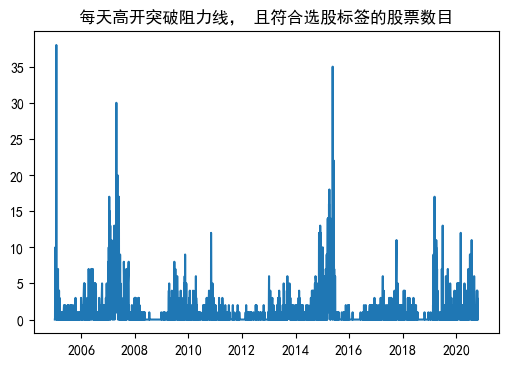

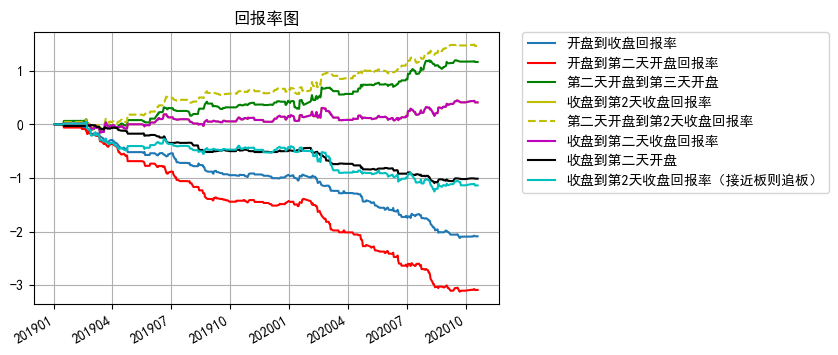

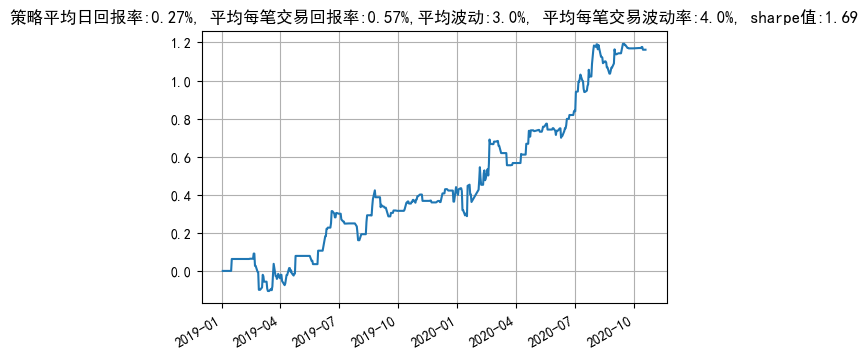

In [35]:
#比较视图cmv_threshold取不同值
cmv_threshold = 50e4
wants = list(np.array(tkrs)[cmv2019>cmv_threshold])
off = 1

print('选股池大小：', len(wants))
q = [list(tkrs).index(x) for x in wants]
idxT = [x in q for x in range(len(tkrs))]
idxQsub = np.array(np.zeros(close_mtx.shape), dtype='bool')
#idxT每天有多少是高开的
for k in range(close_mtx.shape[1]-1):
    idxQsub[:, k+1] = idxQ[:, k+1] & idxT

[r1c,r2c,r3c,r4c,r5c,r6c,r7c,r8c, dc] = calculateProfit(idxQsub, '每天高开突破阻力线， 且符合选股标签的股票数目', detail='no',detailTrade=3, off=off, startDate=startDate)
rschLib.drawPNL(dtesUsed, r3c,dtes, strategy_name)


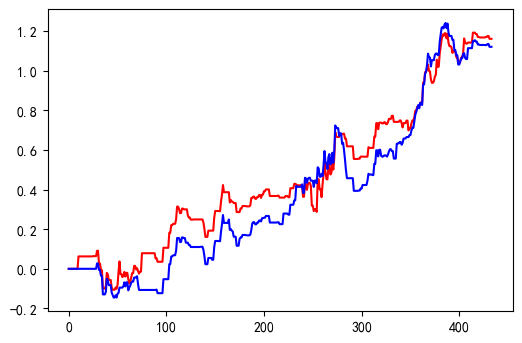

In [36]:
plt.plot(np.cumsum(r3c), 'r')
plt.plot(np.cumsum(r3), 'b')

In [37]:
#load_ext line_profiler
# #%lprun -f getPnl getPnl()